### **3\. ETL**

 A etapa de **extração, transformação e carregamento** (*ETL*) é crucial para a manipulação dos dados que foram ingeridos e persistidos nas camadas cruas ou *raw* dos sistemas analíticos. Em resumo, essa etapa envolve a transformação dos dados brutos em um formato mais estruturado e útil para análise. O processo geralmente inclui a limpeza dos dados, remoção de duplicatas, particionamento, orientação a coluna e compressão, preparando o dado para análises posteriores.

Nesse projeto, as mensagens coletadas ao longo de um único dia são compactadas em um único arquivo, orientado a coluna e comprimido, que é então armazenado na camada enriquecida. Além disso, o processo inclui diversas etapas de *data wrangling* para garantir a qualidade dos dados.

Para implementar isso, utilizei uma função do `AWS Lambda` para processar os dados e um bucket do` AWS S3` como a camada enriquecida onde os dados processados são armazenados. Para assegurar que o processo aconteça diariamente, configurei uma regra no `AWS EventBridge` como gatilho para a função do `AWS Lambda`.

### **3.1. AWS S3**

Na etapa de **ETL**, o `AWS S3` é utilizado para armazenar os dados processados de cada dia em um único arquivo no formato Parquet. Para isso, criei um *bucket* específico para a camada enriquecida, seguindo o padrão de nomenclatura com o sufixo `-enriched`.

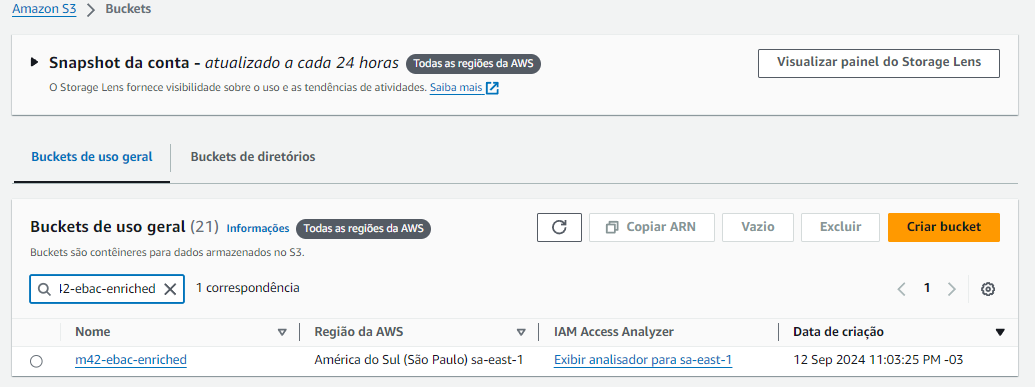

> **Nota:** Um `data lake` é um repositório para grandes volumes de dados, organizado em zonas que armazenam dados em diferentes níveis de processamento. As zonas mais comuns são *raw* e *enriched* ou *bronze*, *silver* e *gold*.

### **3.2. AWS Lambda**

No processo de **ETL**, a função do `AWS Lambda` é responsável por processar as mensagens armazenadas na camada cru do *bucket* do `AWS S3` e movê-las para a camada enriquecida. A função é projetada para:

 - Listar todos os arquivos JSON de um único dia na camada cru do *bucket* do `AWS S3`;
 - Para cada arquivo listado:
  - Fazer o *download* do arquivo e carregar o conteúdo da mensagem;
  - Executar funções de *data wrangling* para preparar os dados;
  - Criar uma tabela com PyArrow e combinar com as tabelas anteriores.
 - Persistir a tabela resultante no formato Parquet na camada enriquecida, também em um *bucket* do` AWS S3`.

> **Nota**: Utilizar duas camadas de armazenamento e processamento permite a reprocessamento dos dados crus sempre que necessário.

> **Nota**: A função processa as mensagens do dia anterior (D-1).

O código da função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

O código da função de data *wrangling*:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Para garantir que a função do AWS Lambda funcione corretamente, foram realizadas as seguintes configurações:

 - **Variáveis de ambiente**

O código da função exige duas variáveis de ambiente: `AWS_S3_BUCKET` para o bucket da camada cru e `AWS_S3_ENRICHED` para o bucket da camada enriquecida. Para configurar essas variáveis no `AWS Lambda`, acesse o console da função e vá até **Configurações -> Variáveis de Ambiente**.

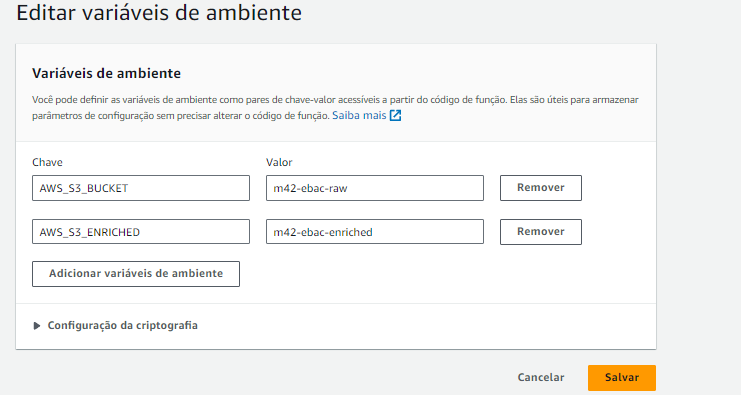

 - **Permissão**

Foi necessário adicionar permissões de escrita nos *buckets* do` AWS S3` para a função do `AWS Lambda`. Isso foi feito no `AWS IAM`, garantindo que a função possa acessar e gravar dados nos buckets apropriados.  Para fins educativos, adicionaremos a permissão AmazonS3FullAccess. No entanto, na prática, o ideal é selecionar os buckets corretos e configurar configurações mais restritivas para garantir a segurança.

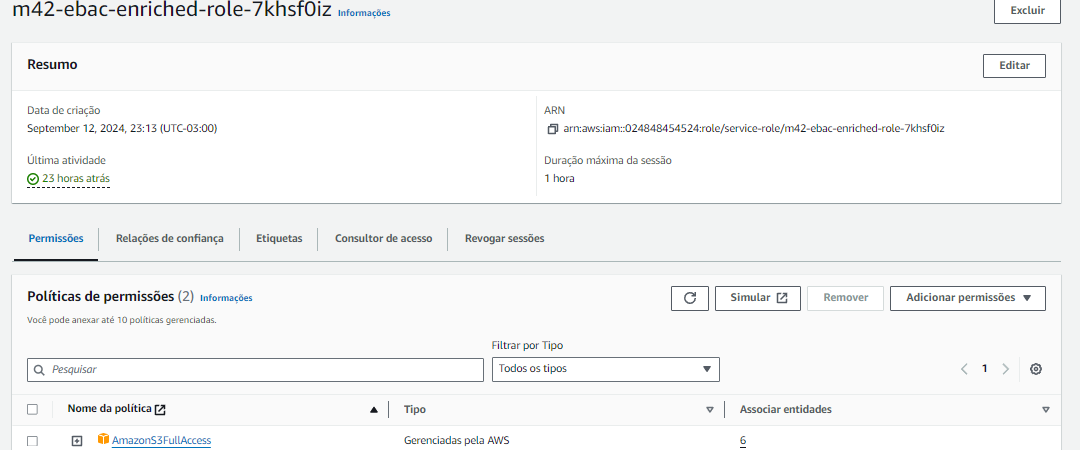

 - **Recursos**

O *timeout* padrão para funções do` AWS Lambda` é de 3 segundos, mas para essa função, que realiza operações de IO com arquivos do `AWS S3`, aumentei o tempo limite para 5 minutos para assegurar que o processamento de arquivos maiores seja concluído sem interrupções.

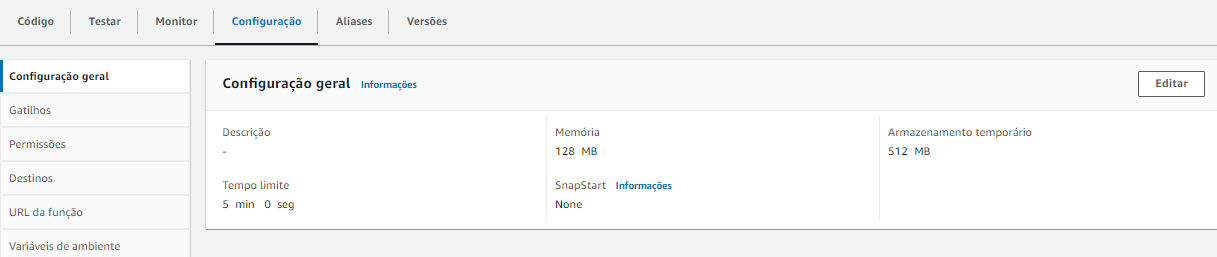

 - **Camadas**

A função utiliza o pacote Python PyArrow, que não está disponível no ambiente padrão do `AWS Lambda`. Para adicionar pacotes externos, optei por usar camadas (*layers*). O processo foi:


 - Criei um *bucket* no `AWS S3`;
 - Fiz o upload do pacote Python PyArrow (o pacote pode ser baixado [aqui](https://github.com/awslabs/aws-data-wrangler/releases));
 - Criei uma camada no AWS Lambda e a conectei à função.

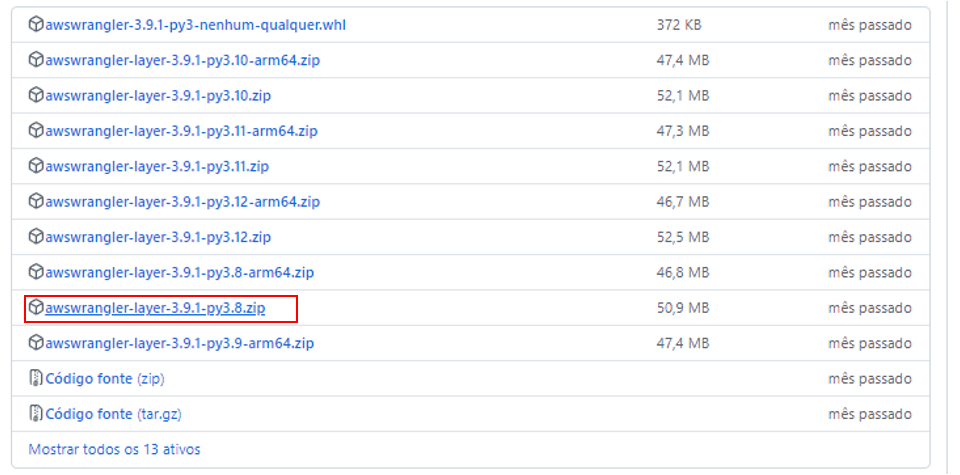

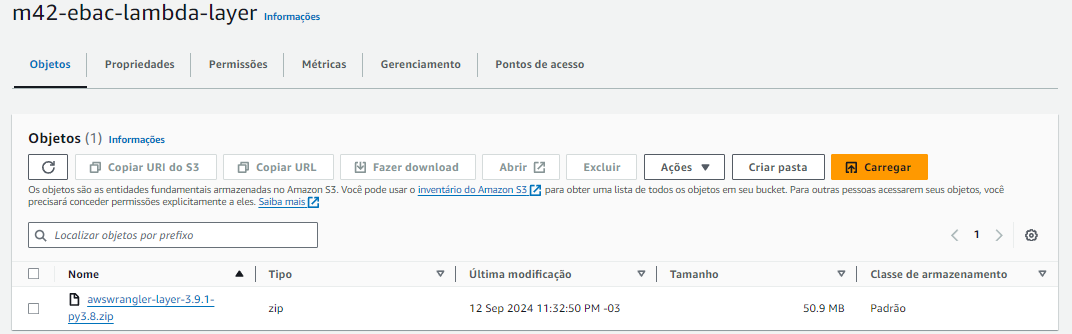

 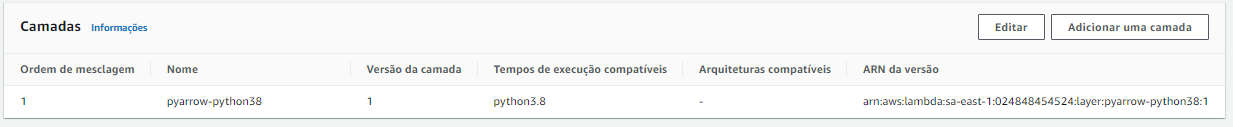

A função foi executada com sucesso, e a resposta foi positiva. O processo levou quase um minuto para ser concluído. Agora, vamos verificar o resultado diretamente no *bucket* do `S3`.

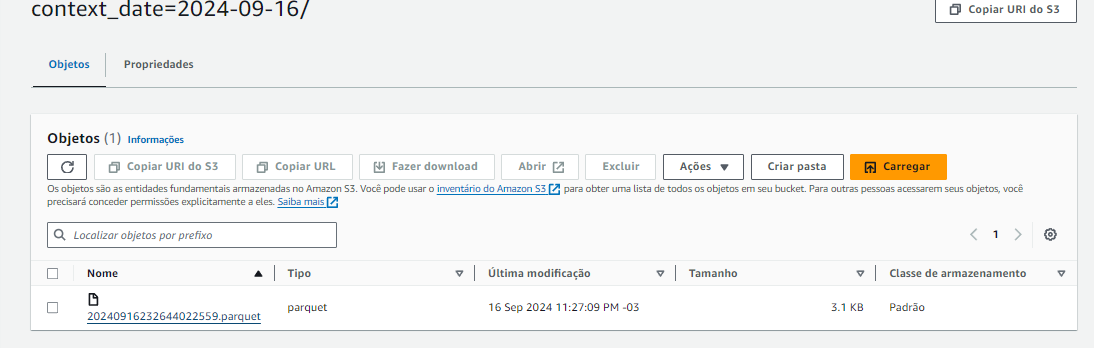

### **3.3. AWS Event Bridge**

Na etapa de **ETL**, utilizei o `AWS EventBridge` para configurar a execução diária da função de **ETL** no `AWS Lambda`, atuando como um agendador (*scheduler*).


> **Nota**: Atente-se ao fato de que a função processa as mensagens do dia anterior (D-1).

Para configurar o` AWS EventBridge`, segui os seguintes passos:

- Acesse o console do `AWS EventBridge` e selecione a opção para criar uma nova regra.
- Configure a regra para ser executada diariamente, usando uma expressão cron para definir o horário desejado.
- Defina a ação da regra para acionar a função do `AWS Lambda` que processa as mensagens.
- Salvei e ativei a regra para garantir que a função de ETL seja acionada conforme o cronograma estabelecido.

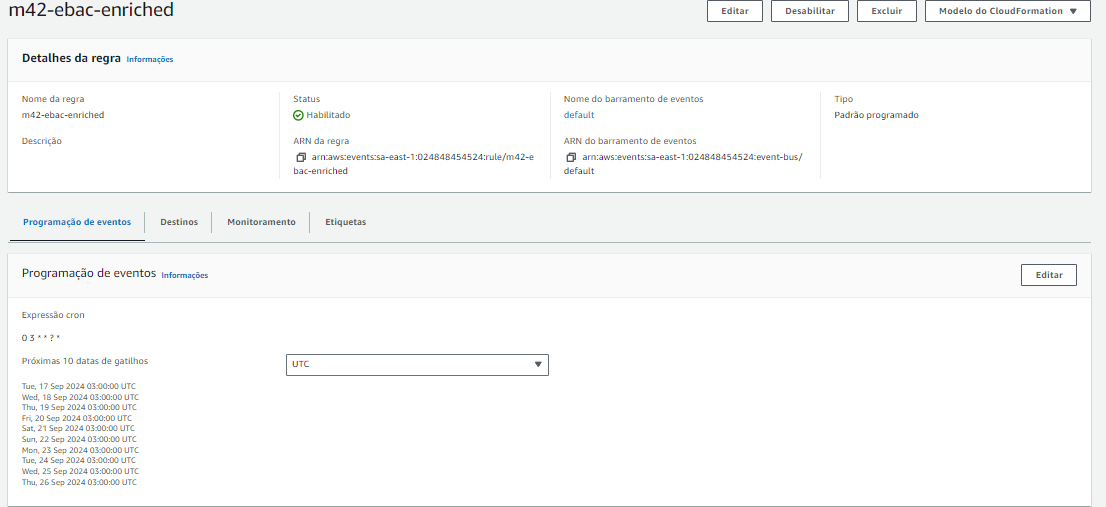

Assim, o `AWS EventBridge` garante que a função de ETL seja executada automaticamente todos os dias, processando as mensagens do dia anterior e mantendo a camada enriquecida atualizada.